In [170]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
os.chdir('C:/Users/anike/Downloads/datasets/QLC')



In [171]:
xlx = pd.read_excel('QLC_Assignment.xlsx')
xls = pd.ExcelFile('QLC_Assignment.xlsx')

data = pd.read_excel(xls, sheetname="Data")
data['Date'] = pd.to_datetime(data['Date'])

In [172]:
df = data.copy()

In [173]:
data.head()

,Date,Day,Accounts,New -IN,IN,OUT,launch Count
0,2016-01-12,Saturday,8860,5480,52140,51280,101340
1,2016-02-12,Sunday,3040,800,12180,16400,37540
2,2016-03-12,Monday,9660,4900,66460,58220,106900
3,2016-04-12,Tuesday,10040,2920,70880,64560,109780
4,2016-05-12,Wednesday,10120,3200,73740,66920,110120


In [174]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

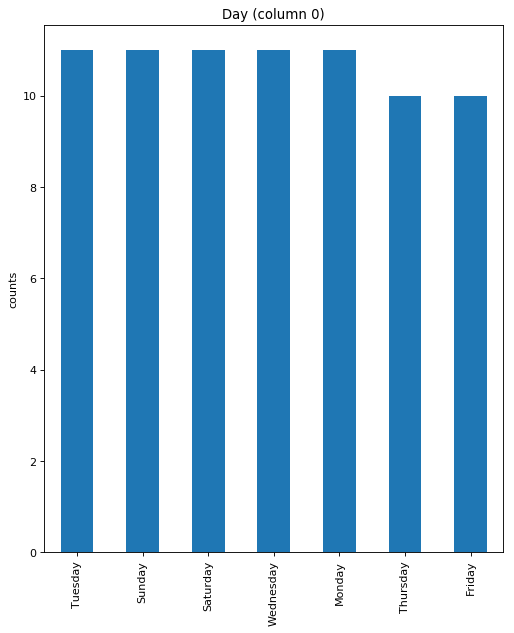

In [175]:
def plotPerColumnDistribution(data, nGraphShown, nGraphPerRow):
    nunique = data.nunique()
    data = data[[col for col in data if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = data.shape
    columnNames = list(data)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columndata = data.iloc[:, i]
        if (not np.issubdtype(type(columndata.iloc[0]), np.number)):
            valueCounts = columndata.value_counts()
            valueCounts.plot.bar()
        else:
            columndata.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
plotPerColumnDistribution(data, 10, 7)

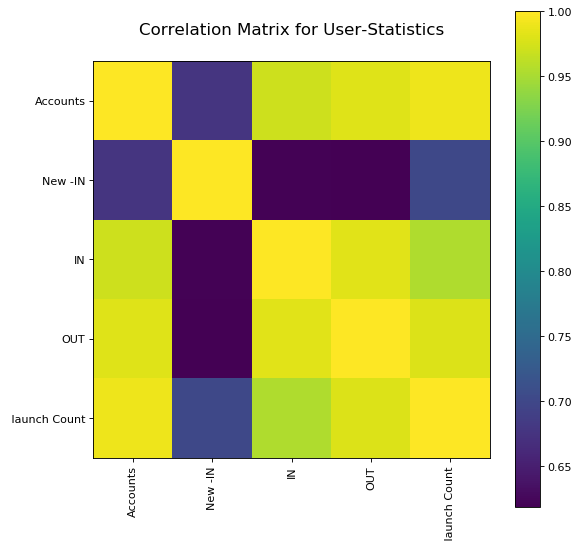

In [176]:
def plotCorrelationMatrix(data, graphWidth):
    filename = 'User-Statistics'
    data = data.dropna('columns') # drop columns with NaN
    data = data[[col for col in data if data[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if data.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({data.shape[1]}) is less than 2')
        return
    corr = data.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
plotCorrelationMatrix(data, 8)

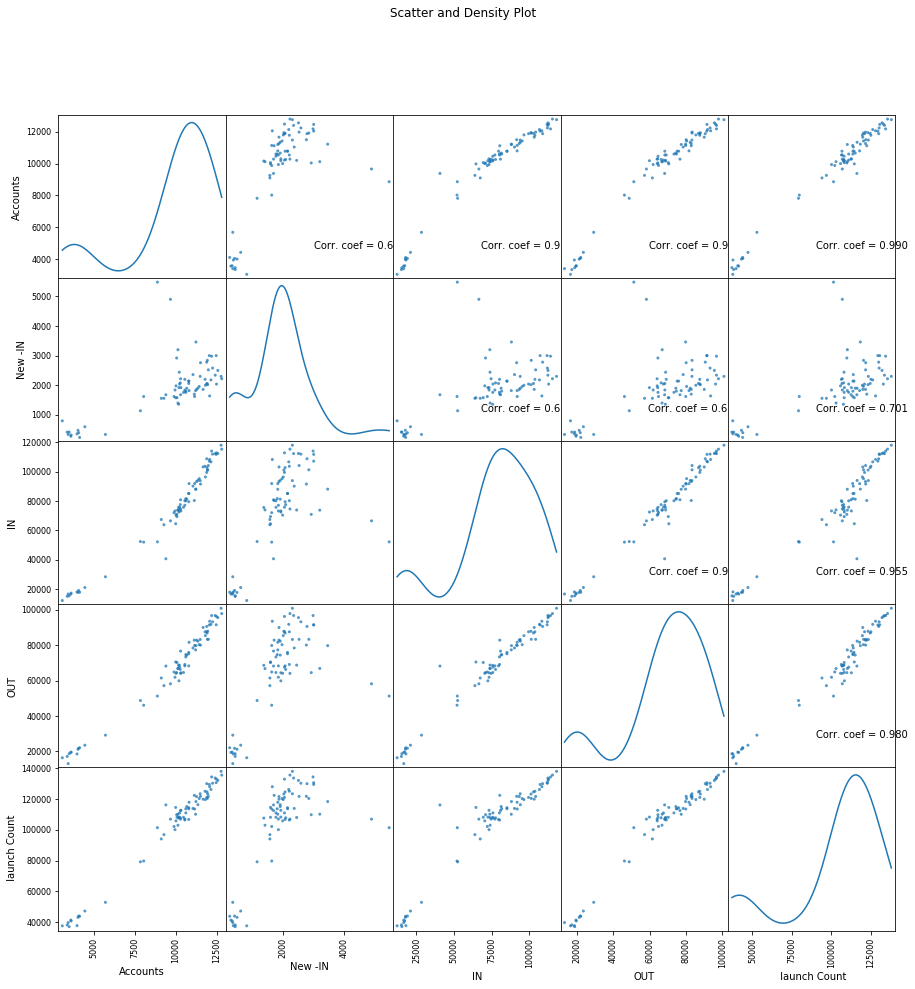

In [177]:
def plotScatterMatrix(data, plotSize, textSize):
    data = data.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to data being singular
    data = data.dropna('columns')
    data = data[[col for col in data if data[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(data)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    data = data[columnNames]
    ax = pd.plotting.scatter_matrix(data, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = data.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()
plotScatterMatrix(data, 15, 10)

In [178]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['Day'] = le.fit_transform(data['Day'])

In [179]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')


['Day', 'Accounts', 'New -IN', 'IN', 'OUT', ' launch Count']


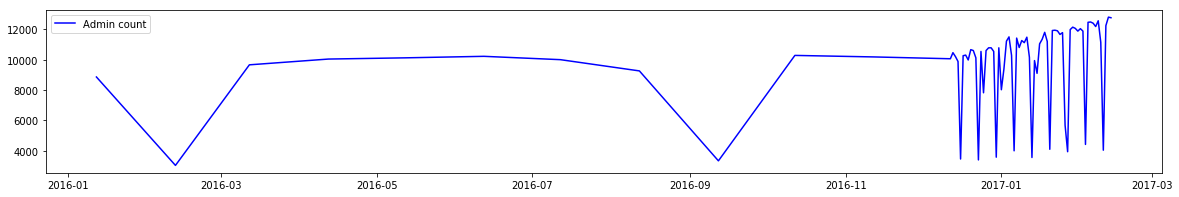

In [180]:
print(data.columns.tolist())
plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='Admin count')
plt.legend(loc='best')

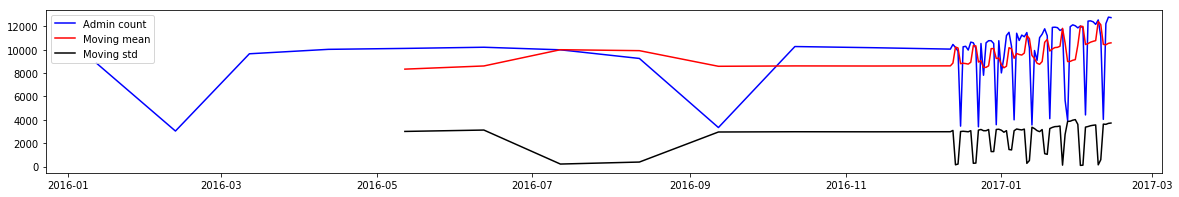

In [181]:
#check for stationerity
moving_mean = data['Accounts'].rolling(5).mean()
moving_std = data['Accounts'].rolling(5).std()
plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='Admin count')
plt.plot(moving_mean, color='red', label='Moving mean')
plt.plot(moving_std, color='black', label = 'Moving std')
plt.legend(loc='best')

In [182]:
#Dicker fuller test for stationerity
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(data['Accounts'].values)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -0.902945
p-value                         0.787001
#Lags Used                      7.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In [183]:
#taking log to decrease the p-value.
import math

log_train = data
log_train = log_train["Accounts"].apply(lambda x: math.log(x+1))
log_train = pd.DataFrame(log_train)

dftest = adfuller(log_train['Accounts'].values)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)


Test Statistic                 -1.248008
p-value                         0.652611
#Lags Used                      7.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


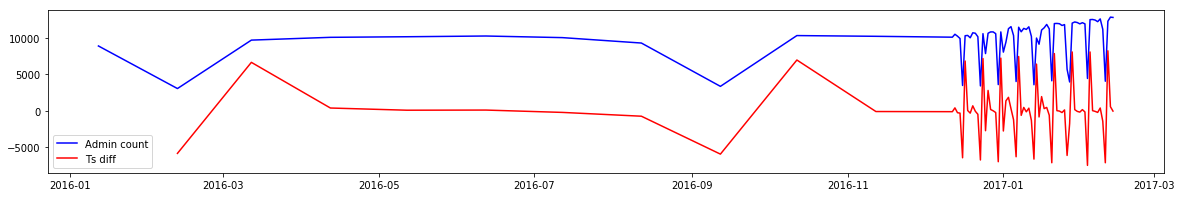

In [184]:
ts_diff = data['Accounts'] - data['Accounts'].shift()
plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='Admin count')
plt.plot(ts_diff, color='red', label='Ts diff')
plt.legend(loc='best')

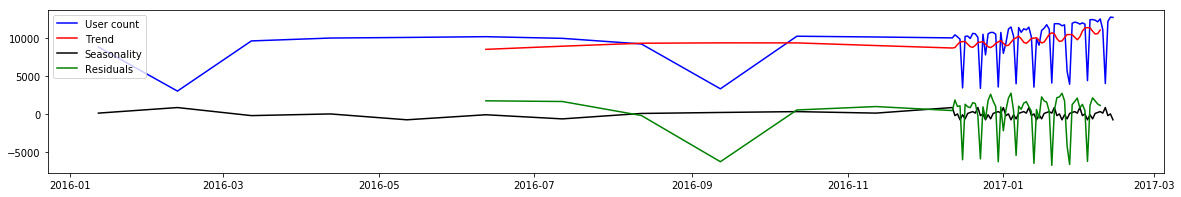

In [185]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Accounts'],freq = 10)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='User count')
plt.plot(trend, color='red', label='Trend')
plt.plot(seasonal, color='black', label='Seasonality')
plt.plot(residual, color='green', label='Residuals')
plt.legend(loc='best')

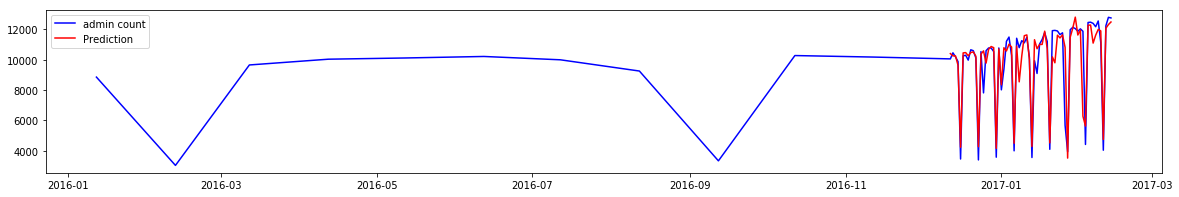

In [186]:
from statsmodels.tsa.ar_model import AR

# fit model
model = AR(data['Accounts'])
model_fit = model.fit()
# make prediction
pred_users = model_fit.predict(11,74)
# plot
plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='admin count')
plt.plot(pred_users, color='red', label='Prediction')
plt.legend(loc='best')

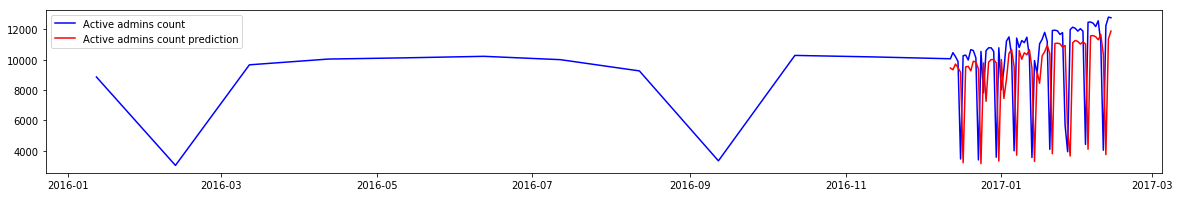

In [187]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(data['Accounts'])
model_fit = model.fit()
# make prediction
sarima_pred = model_fit.predict(11, 74)
plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='Active admins count')
plt.plot(sarima_pred, color='red',label='Active admins count prediction')
plt.legend(loc='best')

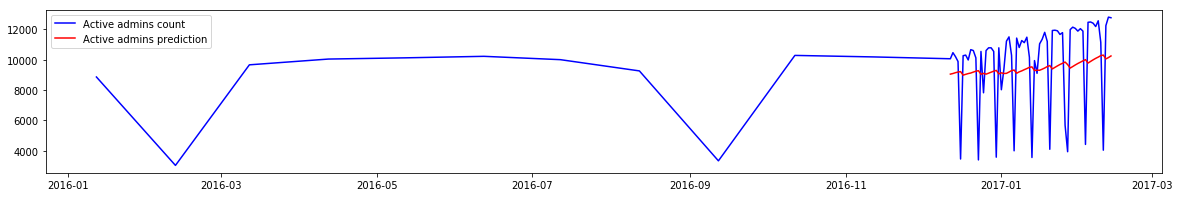

In [188]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
# fit model
model = SimpleExpSmoothing(data['Accounts'])
model_fit = model.fit()
# make prediction
pred_holtwint = model_fit.predict(11, 74)
plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='Active admins count')
plt.plot(pred_holtwint, color='red',label='Active admins prediction')
plt.legend(loc='best')

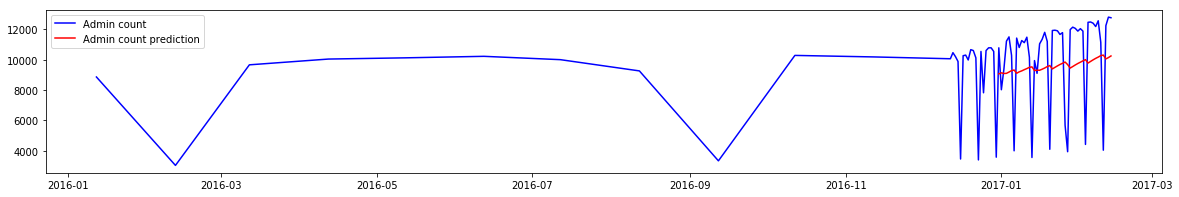

In [189]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# fit model
model = ExponentialSmoothing(data['Accounts'])
model_fit = model.fit()
# make prediction
hwt_pred = model_fit.predict(30, 74)
plt.figure(figsize=(20, 3))
plt.plot(data['Accounts'], color='blue',label='Admin count')
plt.plot(hwt_pred, color='red',label='Admin count prediction')
plt.legend(loc='best')

In [190]:
#From plot we can consider AR model is the best fit model for this timeseries
import datetime
from sklearn.metrics import mean_squared_error
x_train = data[data.index <datetime.datetime(2017, 1, 20)]
x_test = data[data.index >=datetime.datetime(2017, 1, 20)]

5040.915820946449


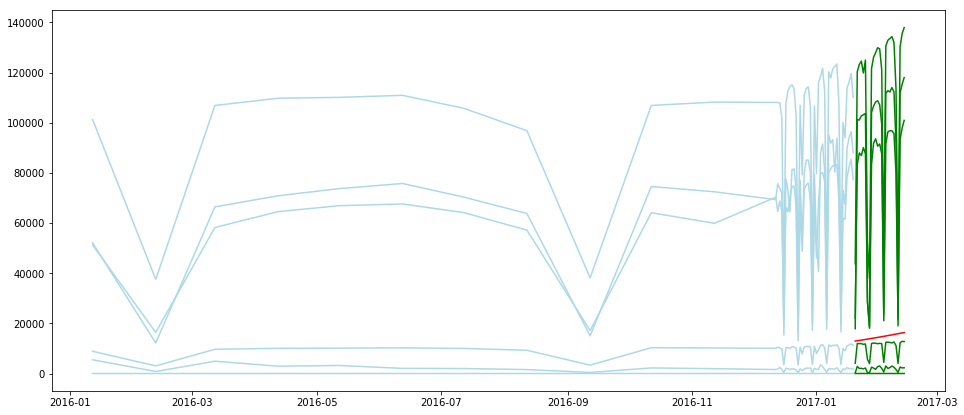

In [198]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(log_train, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")

## Forecasting 
pred = pd.DataFrame(results_AR.forecast(len(x_test))[0])
pred.columns = ["yhat"]
pred.index = x_test.index

## Converting from log to normal value
pred["yhat"] = pred["yhat"].apply(lambda x: math.exp(x)-1)

## Measuring error. 
measure = math.pow(mean_squared_error(x_test['Accounts'].values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

                             ARIMA Model Results                              
Dep. Variable:             D.Accounts   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -37.731
Method:                       css-mle   S.D. of innovations              0.391
Date:                Mon, 25 Feb 2019   AIC                             83.461
Time:                        12:34:44   BIC                             92.678
Sample:                             1   HQIC                            87.138
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0037      0.002      1.900      0.061      -0.000       0.007
ar.L1.D.Accounts    -0.0793      0.116     -0.684      0.496      -0.306       0.148
ma.L1.D.Accounts    -0.9999 

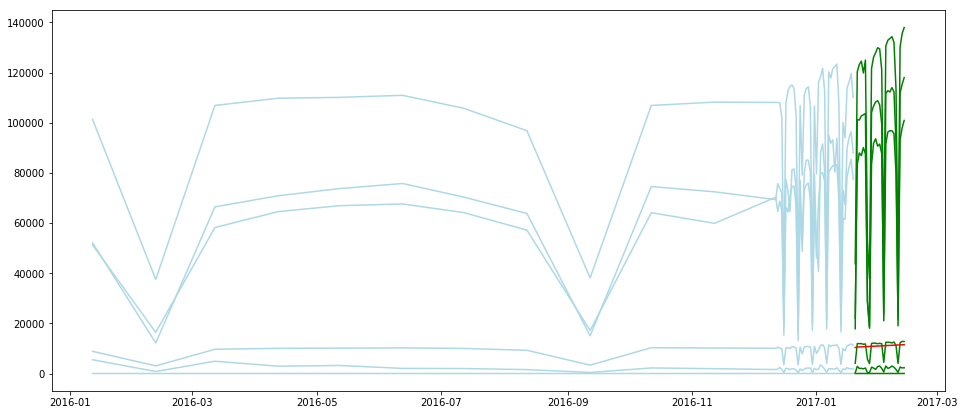

In [199]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(log_train, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())


plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")

## Forecasting 
pred = pd.DataFrame(results_ARIMA.forecast(len(x_test))[0])
pred.columns = ["yhat"]
pred.index = x_test.index

## Converting from log to normal value
pred["yhat"] = pred["yhat"].apply(lambda x: math.exp(x)-1)

## Measuring error. 
measure = math.pow(mean_squared_error(x_test['Accounts'].values, pred.values), 0.5)
print(measure)
plt.plot(pred.index, pred.fillna(0).values, color="red")
plt.show()

# 
REPORT (INSIGHTS)

1) Add new in and in to check on which day most logins are happening.
 
: plotpercolumndisturbition
shows:
WE can see that maximums number of users login are on those particular days.

2) To check the dependency between active admins and user logins.
: correlation matrix :  

    In and out  has high correlation
    in and launch count has high correlation
    out and launch count has high correlation
    in and accounts has high correlation
    out and accounts has high correlation
    launch counts and accounts has high correlation
    new in and accounts has high correlation

3)As a Business Analyst, How would you handle people launching the app numerous times but don't login ?
:- 1) People dont login the reason could be whenever one wants  to use the app he has to login everytime, thus if there is no option to remember credentials than people wont try for thousands of times as they'll get bore it.
:-2) Also if there is some free offers going ...people wont mind logining for everytime eg. googlepay (rewards)


4) We can do this for every column just replace Accounts with that specific column
